# P4Lang Tutorials of FABRIC

This notebook walks the user through setting up a FABRIC eperiment that is suitiable for completing the P4 tutorials created by [P4Lang](https://github.com/p4lang/tutorials). The tutorials were origianlly designed to use a mininet topology. This example replaces the mininet topology with a FABRIC experiemnt topology that may span multiple sites across the FABRIC testbed.

Additional resources:
- [FABRIC Knowledge Base](https://learn.fabric-testbed.net/)
- [FABRIC Forums](https://learn.fabric-testbed.net/forums/)
- [P4Lang Tutorials](https://github.com/p4lang/tutorials)
- [P4Lang YouTube Presentations](https://www.youtube.com/channel/UCOQAFkDKucJWr-KafdJsdIQ)

## Basic FABRIC Slice Configuration

In [15]:
import os
from fabrictestbed.slice_manager import SliceManager, Status, SliceState
import json

In [16]:
bastion_username = 'pruth'

bastion_key_filename = os.environ['HOME'] + "/work/id_rsa_fabric"

ssh_key_file_priv=os.environ['HOME']+"/.ssh/id_rsa"
ssh_key_file_pub=os.environ['HOME']+"/.ssh/id_rsa.pub"

ssh_key_pub = None
with open (ssh_key_file_pub, "r") as myfile:
    ssh_key_pub=myfile.read()
    ssh_key_pub=ssh_key_pub.strip()
    

In [17]:
credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
print(f"FABRIC Credential Manager   : {credmgr_host}")

orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"FABRIC Orchestrator         : {orchestrator_host}")

FABRIC Credential Manager   : cm.fabric-testbed.net
FABRIC Orchestrator         : orchestrator.fabric-testbed.net


### Create Slice Manager Object
Users can request tokens with different Project and Scopes by altering `project_name` and `scope` parameters in the refresh call below.

In [18]:
slice_manager = SliceManager(oc_host=orchestrator_host, 
                             cm_host=credmgr_host ,
                             project_name='all', 
                             scope='all')

# Initialize the slice manager
slice_manager.initialize()

### (Optional) Orchestrator API example to query for available resources

In [19]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
if status == Status.OK:
    print(f"Toplogy: {advertised_topology}")
else:
    print(f"Error: {advertised_topology}")

Status: Status.OK
Toplogy: NCSA: { cpu: 6/6 , core: 164/192 , ram: 1,414/1,536 G, disk: 60,180/60,600 G, unit: 3/3 }
	Components:
		NVME-P4510:  NVME P4510 { disk: 8,640/9,600 G, unit: 9/10 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 2/2 }
		GPU-RTX6000:  GPU RTX6000 { unit: 3/3 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 1/2 }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 0/2 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 376/381 }
	Site Interfaces:
		NCSA_STAR: TrunkPort { bw: 100/100 Gbps}
TACC: { cpu: 10/10 , core: 270/320 , ram: 2,264/2,560 G, disk: 114,720/116,400 G, unit: 5/5 }
	Components:
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2 }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 3/4 }
		GPU-RTX6000:  GPU RTX6000 { unit: 6/6 }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4 }
		NVME-P4510:  NVME P4510 { disk: 15,360/15,360 G, unit: 16/16 }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 615/635 }
	Site Interfaces:
		TACC_MAX: TrunkPort { b

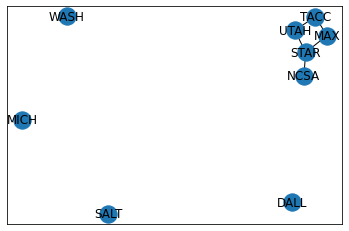

In [20]:
if status == Status.OK:
    advertised_topology.draw()

### Utility Functions

Commonly used functions.

In [7]:
import paramiko
from ipaddress import ip_address, IPv4Address

bastion_public_addr = 'bastion-1.fabric-testbed.net'
bastion_private_ipv4_addr = '192.168.11.226'
bastion_private_ipv6_addr = '2600:2701:5000:a902::c'

def validIPAddress(IP: str) -> str:
    try:
        return "IPv4" if type(ip_address(IP)) is IPv4Address else "IPv6"
    except ValueError:
        return "Invalid"

def execute_script(node_username, node, script):
    import paramiko

    try:
        management_ip = str(node.get_property(pname='management_ip'))
        #print("Node {0} IP {1}".format(node.name, management_ip))

        key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

        bastion=paramiko.SSHClient()
        bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename)

        bastion_transport = bastion.get_transport()
        if validIPAddress(management_ip) == 'IPv4':
            src_addr = (bastion_private_ipv4_addr, 22)
        elif validIPAddress(management_ip) == 'IPv6':
            src_addr = (bastion_private_ipv6_addr, 22)
        else:
            return 'Management IP Invalid: {}'.format(management_ip)

        dest_addr = (management_ip, 22)
        bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        client.connect(management_ip,username=node_username,pkey = key, sock=bastion_channel)

        stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
        stdout_str = str(stdout.read(),'utf-8').replace('\\n','\n')
        #print ('')
        #print (str(stdout.read(),'utf-8').replace('\\n','\n'))
        #print (str(stderr.read()))

        client.close()
    except Exception as e:
        print(str(e))
        return str(e)

    return stdout_str


def upload_file(node_username, node, local_file_path, remote_file_path):
    import paramiko

    try:
        management_ip = str(node.get_property(pname='management_ip'))
        #print("Node {0} IP {1}".format(node.name, management_ip))

        key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

        bastion=paramiko.SSHClient()
        bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename)

        bastion_transport = bastion.get_transport()
        if validIPAddress(management_ip) == 'IPv4':
            src_addr = (bastion_private_ipv4_addr, 22)
        elif validIPAddress(management_ip) == 'IPv6':
            src_addr = (bastion_private_ipv6_addr, 22)
        else:
            return 'Management IP Invalid: {}'.format(management_ip)

        dest_addr = (management_ip, 22)
        bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        client.connect(management_ip,username=node_username,pkey = key, sock=bastion_channel)

        ftp_client=client.open_sftp()
        file_attributes = ftp_client.put(local_file_path, remote_file_path)
        ftp_client.close()

        client.close()
    except Exception as e:
        print(str(e))
        return str(e)

    return file_attributes

def download_file(node_username, node, local_file_path, remote_file_path):
    import paramiko

    try:
        management_ip = str(node.get_property(pname='management_ip'))
        #print("Node {0} IP {1}".format(node.name, management_ip))

        key = paramiko.RSAKey.from_private_key_file(ssh_key_file_priv)

        bastion=paramiko.SSHClient()
        bastion.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        bastion.connect(bastion_public_addr, username=bastion_username, key_filename=bastion_key_filename)

        bastion_transport = bastion.get_transport()
        if validIPAddress(management_ip) == 'IPv4':
            src_addr = (bastion_private_ipv4_addr, 22)
        elif validIPAddress(management_ip) == 'IPv6':
            src_addr = (bastion_private_ipv6_addr, 22)
        else:
            return 'Management IP Invalid: {}'.format(management_ip)

        dest_addr = (management_ip, 22)
        bastion_channel = bastion_transport.open_channel("direct-tcpip", dest_addr, src_addr)


        client = paramiko.SSHClient()
        client.load_system_host_keys()
        client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())
        client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

        client.connect(management_ip,username=node_username,pkey = key, sock=bastion_channel)

        ftp_client=client.open_sftp()
        file_attributes = ftp_client.get(local_file_path, remote_file_path)
        ftp_client.close()

        client.close()
    except Exception as e:
        print(str(e))
        return str(e)

    return file_attributes

import time
def wait_for_slice(slice,timeout=180,interval=10,progress=False):
    timeout_start = time.time()

    if progress: print("Waiting for slice .", end = '')
    while time.time() < timeout_start + timeout:
        return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

        if return_status == Status.OK:
            slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
            if slice.slice_state == "StableOK":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice
            if slice.slice_state == "Closing" or slice.slice_state == "Dead":
                if progress: print(" Slice state: {}".format(slice.slice_state))
                return slice    
        else:
            print(f"Failure: {slices}")
        
        if progress: print(".", end = '')
        time.sleep(interval)
    
    if time.time() >= timeout_start + timeout:
        if progress: print(" Timeout exceeded ({} sec). Slice: {} ({})".format(timeout,slice.slice_name,slice.slice_state))
        return slice   
    
    
def ping_test(node, ping_target_ip, verbose=False):
    if verbose: print("Ping Test: {}".format(ping_target_ip),end='')

    #rtt min/avg/max/mdev = 0.063/0.119/0.189/0.053 ms
    #output = "Information about latency with ping: \n"
    
    try:
        #ping up
        raw_output = execute_script(username, node, 'ping -c 3 ' + ping_target_ip + ' | grep rtt')
        #raw_output = stdout.read().decode("utf-8")
        raw_data = raw_output.split(" ")[3]
        data_array = raw_data.split("/")
        avg_rtt = data_array[1]

        if verbose: print(", ping success! avg_rtt: {}".format(avg_rtt))
    except Exception as e:
        if verbose: print(", ping failed: {}".format(str(e)))
        return float(0)
        
    return float(avg_rtt)

def find_nic_mapping(net_name, nodes):
    return_data = {}
   
    #copy scripts to nodes   
    for node in nodes:
        #config node1
        file_attributes = upload_file(username, node, 'scripts/host_set_all_dataplane_ips.py','host_set_all_dataplane_ips.py')
        #print("file_attributes: {}".format(file_attributes))
        file_attributes = upload_file(username, node, 'scripts/find_nic_mapping.py','find_nic_mapping.py')
        #print("file_attributes: {}".format(file_attributes))
        
    
    #Config target node
    target_node = nodes[0]
    stdout = execute_script(username, target_node, 'sudo python3 host_set_all_dataplane_ips.py')
    #print("stdout: {}".format(stdout))
    #print(stdout)

    target_ifaces = json.loads(stdout.replace('\n',''))
    #print(ifaces)
    #for i in ifaces['management']:
    #    print(i)
        
    #for i in ifaces['dataplane']:
    #    print(i)
    #node1_map = { 'data' : {'ens6': '192.168.1.100', etc... }, 'management': { 'ens3': '10.1.1.1'}  }
    

    # Test s1 ifaces
    target_net_ip = None
    for node in nodes:
        #skip target node
        if node == target_node:
            continue

        #test node interfaces against target 
        for target, ip in target_ifaces['dataplane']:
            node1_dataplane_ip = ip
            node2_dataplane_ip = ip.replace('100','101')
            node2_cidr = '24'
            #node2_management_ip = str(node2.management_ip)
            #print("S1 Name        : {}".format(node2.name))
            #print("Management IP    : {}".format(node2_management_ip))

            stdout = execute_script(username, node, 'python3 find_nic_mapping.py {} {} {} {}'.format('net',node2_dataplane_ip,node2_cidr,node1_dataplane_ip) )
            iface =  stdout.replace('\n','')
            #print("stdout: {}".format(stdout))
            if iface != 'None':
                #print(iface)
                #return iface
                if target_net_ip == None:
                    return_data[target_node.name]=target
                return_data[node.name]=iface
                break

    
    
    return return_data



def find_nic_mapping_vlan(net_name, vlan, nodes):
    return_data = {}
   
    #copy scripts to nodes   
    for node in nodes:
        #config node1
        file_attributes = upload_file(username, node, 'scripts/host_set_all_dataplane_ips_vlan.py','host_set_all_dataplane_ips_vlan.py')
        #print("file_attributes: {}".format(file_attributes))
        file_attributes = upload_file(username, node, 'scripts/find_nic_mapping.py','find_nic_mapping.py')
        #print("file_attributes: {}".format(file_attributes))
        
    
    #Config target node
    target_node = nodes[0]
    stdout = execute_script(username, target_node, f'sudo python3 host_set_all_dataplane_ips_vlan.py {vlan}')
    #print("stdout: {}".format(stdout))
    #print(stdout)

    target_ifaces = json.loads(stdout.replace('\n',''))
    #print(ifaces)
    #for i in ifaces['management']:
    #    print(i)
        
    #for i in ifaces['dataplane']:
    #    print(i)
    #node1_map = { 'data' : {'ens6': '192.168.1.100', etc... }, 'management': { 'ens3': '10.1.1.1'}  }
    

    # Test s1 ifaces
    target_net_ip = None
    for node in nodes:
        #skip target node
        if node == target_node:
            continue

        #test node interfaces against target 
        for target, ip in target_ifaces['dataplane']:
            node1_dataplane_ip = ip
            node2_dataplane_ip = ip.replace('100','101')
            node2_cidr = '24'
            #node2_management_ip = str(node2.management_ip)
            #print("S1 Name        : {}".format(node2.name))
            #print("Management IP    : {}".format(node2_management_ip))

            stdout = execute_script(username, node, 'python3 find_nic_mapping.py {} {} {} {}'.format('net',node2_dataplane_ip,node2_cidr,node1_dataplane_ip) )
            iface =  stdout.replace('\n','')
            #print("stdout: {}".format(stdout))
            if iface != 'None':
                #print(iface)
                #return iface
                if target_net_ip == None:
                    return_data[target_node.name]=target
                return_data[node.name]=iface
                break

    
    return return_data

def flush_dataplane_ips(nodes):
    
    for node in nodes:
        #config node1
        file_attributes = upload_file(username, node, 'scripts/host_flush_all_dataplane_ips_vlan.py','host_flush_all_dataplane_ips_vlan.py')
        #print("file_attributes: {}".format(file_attributes))

        stdout = execute_script(username, node, 'sudo python3 host_flush_all_dataplane_ips_vlan.py')
        #print("stdout: {}".format(stdout))
        #print(stdout)
    

def flush_all_dataplane_ips():
    for node_name, node in experiment_topology.nodes.items():
        flush_dataplane_ips([node])
    
    
    
  

## Configure Slice Parameters

This section builds the experiment slice 

<img src="figs/topo.png" width="800"/>



In [8]:
# Slice 
slice_name = 'P4Lang_Tutorial_VLAN'

# Switches
s1_name = "s1"
s2_name = "s2"
s3_name = "s3"

switch_cores = 4
switch_ram = 16
switch_disk = 50

# Hosts
h1_name = "h1"
h2_name = "h2"
h3_name = "h3"

h1_ip="10.0.1.1"
h1_ip="10.0.2.2"
h1_ip="10.0.3.3"

host_cores = 2
host_ram = 8
host_disk = 10

# Sites
site_1 = 'MAX'
site_2 = 'NCSA'
site_3 = 'TACC'

# All node properties
username = 'ubuntu'
image = 'default_ubuntu_20'
image_type = 'qcow2'



### Create the Slice

In [9]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, ComponentModelType, ServiceType
# Create topology
experiment = ExperimentTopology()

# Create Switches
s1 = experiment.add_node(name=s1_name, site=site_1)
cap = Capacities()
cap.set_fields(core=switch_cores, ram=switch_ram, disk=switch_disk)
s1.set_properties(capacities=cap, image_type=image_type, image_ref=image)
s1.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name="s1_switch_nic")
s1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name="s1_host_nic")
s1_interfaces = {}
s1_interfaces['iface_s2'] = list(filter(lambda x : x.name == "s1_switch_nic-p1", s1.interface_list))[0]
if_labels = s1_interfaces['iface_s2'].get_property(pname="labels")
if_labels.vlan = "200"
s1_interfaces['iface_s2'].set_properties(labels=if_labels)

s1_interfaces['iface_s3'] = list(filter(lambda x : x.name == "s1_switch_nic-p2", s1.interface_list))[0]
if_labels = s1_interfaces['iface_s3'].get_property(pname="labels")
if_labels.vlan = "200"
s1_interfaces['iface_s3'].set_properties(labels=if_labels)

s1_interfaces['iface_h1'] = list(filter(lambda x : x.name == "s1_host_nic-p1", s1.interface_list))[0]


s2 = experiment.add_node(name=s2_name, site=site_2)
cap = Capacities()
cap.set_fields(core=switch_cores, ram=switch_ram, disk=switch_disk)
s2.set_properties(capacities=cap, image_type=image_type, image_ref=image)
s2.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name="s2_switch_nic")
s2.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name="s2_host_nic")
s2_interfaces = {}
s2_interfaces['iface_s1'] = list(filter(lambda x : x.name == "s2_switch_nic-p1", s2.interface_list))[0]
if_labels = s2_interfaces['iface_s1'].get_property(pname="labels")
if_labels.vlan = "200"
s2_interfaces['iface_s1'].set_properties(labels=if_labels)

s2_interfaces['iface_s3'] = list(filter(lambda x : x.name == "s2_switch_nic-p2", s2.interface_list))[0]
if_labels = s2_interfaces['iface_s3'].get_property(pname="labels")
if_labels.vlan = "200"
s2_interfaces['iface_s3'].set_properties(labels=if_labels)

s2_interfaces['iface_h2'] = list(filter(lambda x : x.name == "s2_host_nic-p1", s2.interface_list))[0]


s3 = experiment.add_node(name=s3_name, site=site_3)
cap = Capacities()
cap.set_fields(core=switch_cores, ram=switch_ram, disk=switch_disk)
s3.set_properties(capacities=cap, image_type=image_type, image_ref=image)
s3.add_component(model_type=ComponentModelType.SmartNIC_ConnectX_5, name="s3_switch_nic")
s3.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name="s3_host_nic")
s3_interfaces = {}
s3_interfaces['iface_s1'] = list(filter(lambda x : x.name == "s3_switch_nic-p1", s3.interface_list))[0]
if_labels = s3_interfaces['iface_s1'].get_property(pname="labels")
if_labels.vlan = "200"
s3_interfaces['iface_s1'].set_properties(labels=if_labels)

s3_interfaces['iface_s2'] = list(filter(lambda x : x.name == "s3_switch_nic-p2", s3.interface_list))[0]
if_labels = s3_interfaces['iface_s2'].get_property(pname="labels")
if_labels.vlan = "200"
s3_interfaces['iface_s2'].set_properties(labels=if_labels)

s3_interfaces['iface_h3'] = list(filter(lambda x : x.name == "s3_host_nic-p1", s3.interface_list))[0]


#Create Hosts
h1 = experiment.add_node(name=h1_name, site=site_1)
cap = Capacities()
cap.set_fields(core=host_cores, ram=host_ram, disk=host_disk)
h1.set_properties(capacities=cap, image_type=image_type, image_ref=image)
h1.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name="h1_nic")
h1_interfaces = {}
h1_interfaces['iface_s1'] = list(filter(lambda x : x.name == "h1_nic-p1", h1.interface_list))[0]


h2 = experiment.add_node(name=h2_name, site=site_2)
cap = Capacities()
cap.set_fields(core=host_cores, ram=host_ram, disk=host_disk)
h2.set_properties(capacities=cap, image_type=image_type, image_ref=image)
h2.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name="h2_nic")
h2_interfaces = {}
h2_interfaces['iface_s2'] = list(filter(lambda x : x.name == "h2_nic-p1", h2.interface_list))[0]


h3 = experiment.add_node(name=h3_name, site=site_3)
cap = Capacities()
cap.set_fields(core=host_cores, ram=host_ram, disk=host_disk)
h3.set_properties(capacities=cap, image_type=image_type, image_ref=image)
h3.add_component(model_type=ComponentModelType.SharedNIC_ConnectX_6, name="h3_nic")
h3_interfaces = {}
h3_interfaces['iface_s3'] = list(filter(lambda x : x.name == "h3_nic-p1", h3.interface_list))[0]


#Add swtich network connections
experiment.add_network_service(name="net_s1_s2", nstype=ServiceType.L2PTP, interfaces=[s1_interfaces['iface_s2'], s2_interfaces['iface_s1']] )
experiment.add_network_service(name="net_s2_s3", nstype=ServiceType.L2PTP, interfaces=[s2_interfaces['iface_s3'], s3_interfaces['iface_s2']] )
experiment.add_network_service(name="net_s3_s1", nstype=ServiceType.L2PTP, interfaces=[s3_interfaces['iface_s1'], s1_interfaces['iface_s3']] )

#Add host networks 
experiment.add_network_service(name="net_s1_h1", nstype=ServiceType.L2Bridge, interfaces=[s1_interfaces['iface_h1'], h1_interfaces['iface_s1']] )
experiment.add_network_service(name="net_s2_h2", nstype=ServiceType.L2Bridge, interfaces=[s2_interfaces['iface_h2'], h2_interfaces['iface_s2']] )
experiment.add_network_service(name="net_s3_h3", nstype=ServiceType.L2Bridge, interfaces=[s3_interfaces['iface_h3'], h3_interfaces['iface_s3']] )


# Generate Slice Graph
slice_graph = experiment.serialize()

# Request slice from Orchestrator
return_status, slice_reservations = slice_manager.create(slice_name=slice_name, 
                                            slice_graph=slice_graph, 
                                            ssh_key=ssh_key_pub)

if return_status == Status.OK:
    slice_id = slice_reservations[0].get_slice_id()
    print("Submitted slice creation request. Slice ID: {}".format(slice_id))
else:
    print(f"Failure: {slice_reservations}")
  

Submitted slice creation request. Slice ID: 80ea3c2d-7a7c-4c00-96b3-fd821fb24dbd


## Get the Slice

In [21]:
return_status, slices = slice_manager.slices(excludes=[SliceState.Dead,SliceState.Closing])

if return_status == Status.OK:
    slice = list(filter(lambda x: x.slice_name == slice_name, slices))[0]
    slice = wait_for_slice(slice, timeout=600, progress=True)

print()
print("Slice Name : {}".format(slice.slice_name))
print("ID         : {}".format(slice.slice_id))
print("State      : {}".format(slice.slice_state))
print("Lease End  : {}".format(slice.lease_end))

Waiting for slice . Slice state: StableOK

Slice Name : P4Lang_Tutorial_VLAN
ID         : 80ea3c2d-7a7c-4c00-96b3-fd821fb24dbd
State      : StableOK
Lease End  : 2021-12-08 16:50:27


### Get the Topology

In [22]:
return_status, experiment_topology = slice_manager.get_slice_topology(slice_object=slice)

for node_name, node in experiment_topology.nodes.items():
    print("Node:")
    print("   Name              : {}".format(node.name))
    print("   Cores             : {}".format(node.get_property(pname='capacity_allocations').core))
    print("   RAM               : {}".format(node.get_property(pname='capacity_allocations').ram))
    print("   Disk              : {}".format(node.get_property(pname='capacity_allocations').disk))
    print("   Image             : {}".format(node.image_ref))
    print("   Image Type        : {}".format(node.image_type))
    print("   Host              : {}".format(node.get_property(pname='label_allocations').instance_parent))
    print("   Site              : {}".format(node.site))
    print("   Management IP     : {}".format(node.management_ip))
    print("   Reservation ID    : {}".format(node.get_property(pname='reservation_info').reservation_id))
    print("   Reservation State : {}".format(node.get_property(pname='reservation_info').reservation_state))
    print("   Components        :")
    for component_name, component in node.components.items():
        print("      Name             : {}".format(component.name))
        print("      Details          : {}".format(component.details))
        print("      Disk (G)         : {}".format(component.get_property(pname='capacity_allocations').disk))
        print("      Units            : {}".format(component.get_property(pname='capacity_allocations').unit))
        print("      PCI Address      : {}".format(component.get_property(pname='label_allocations').bdf))
        print("      Model            : {}".format(component.model))
        print("      Type             : {}".format(component.type))
    print("   Interfaces        : {}".format(node.interfaces))
    print()    

Node:
   Name              : s1
   Cores             : 4
   RAM               : 16
   Disk              : 100
   Image             : default_ubuntu_20
   Image Type        : qcow2
   Host              : max-w4.fabric-testbed.net
   Site              : MAX
   Management IP     : 63.239.135.91
   Reservation ID    : e80d0fea-da4a-4dc5-8137-9441dbf681e5
   Reservation State : Active
   Components        :
      Name             : s1_switch_nic
      Details          : Mellanox ConnectX-5 Dual Port 10/25GbE
      Disk (G)         : 0
      Units            : 1
      PCI Address      : ['0000:a1:00.0', '0000:a1:00.1']
      Model            : ConnectX-5
      Type             : SmartNIC
      Name             : s1_host_nic
      Details          : Mellanox ConnectX-6 VPI MCX653 dual port 100Gbps
      Disk (G)         : 0
      Units            : 1
      PCI Address      : 0000:e2:02.5
      Model            : ConnectX-6
      Type             : SharedNIC
   Interfaces        : {'s1_switch_

### Find NIC Mappings

In [ ]:
flush_all_dataplane_ips()

iface_map = {}
net = 'net_s1_s2'
print (f'net: {net}')
ifaces = find_nic_mapping(net, [experiment_topology.nodes[s1_name],experiment_topology.nodes[s2_name]] )
iface_map[net] = ifaces

flush_all_dataplane_ips()


net = 'net_s2_s3'
print (f'net: {net}')
ifaces = find_nic_mapping(net, [experiment_topology.nodes[s2_name],experiment_topology.nodes[s3_name]] )
iface_map[net] = ifaces
flush_all_dataplane_ips()


net = 'net_s3_s1'
print (f'net: {net}')
ifaces = find_nic_mapping(net, [experiment_topology.nodes[s3_name],experiment_topology.nodes[s1_name]] )
iface_map[net] = ifaces

flush_all_dataplane_ips()


net = 'net_s1_h1'
print (f'net: {net}')
ifaces = find_nic_mapping(net, [experiment_topology.nodes[s1_name],experiment_topology.nodes[h1_name]] )
iface_map[net] = ifaces

flush_all_dataplane_ips()


net = 'net_s2_h2'
print (f'net: {net}')
ifaces = find_nic_mapping(net, [experiment_topology.nodes[s2_name],experiment_topology.nodes[h2_name]] )
iface_map[net] = ifaces

flush_all_dataplane_ips()


net = 'net_s3_h3'
print (f'net: {net}')
ifaces = find_nic_mapping(net, [experiment_topology.nodes[s3_name],experiment_topology.nodes[h3_name]] )
iface_map[net] = ifaces

flush_all_dataplane_ips()


print (f'{iface_map}')



## Configure Nodes


In [23]:
node_num=1
for host_name in [h1_name, h2_name, h3_name]:
    #Configure h1
    print(f'Configuring {host_name}')
    host = experiment_topology.nodes[host_name]
    host_ip = '10.0.'+str(node_num)+'.'+str(node_num)
    host_cidr = '24'
    host_management_ip = str(host.management_ip)
    print(f'Management IP: {host_management_ip}')
    file_attributes = upload_file(username, host, 'scripts/host_set_dataplane_ip.py','host_set_dataplane_ip.py')
    print("file_attributes: {}".format(file_attributes))
        
    stdout = execute_script(username, host, 'sudo python3 host_set_dataplane_ip.py {} {}'.format(host_ip,host_cidr) )
    print("stdout: {}".format(stdout))
    
    stdout = execute_script(username, host, 'sudo apt-get update -qq && sudo apt-get install -qq -y python3-scapy && git clone https://github.com/p4lang/tutorials.git')
    print("stdout: {}".format(stdout))
    
    node_num = node_num +1


Configuring h1
Management IP: 63.239.135.74
file_attributes: -rw-rw-r--   1 1000     1000         1904 07 Dec 12:17 ?
stdout: Hello from the other side!
Number of arguments: 3 arguments.
Argument List: ['host_set_dataplane_ip.py', '10.0.1.1', '24']
management interface(s): ['ens3']
dataplane interface(s): ['ens7']
Flush iface: ens7
Setting iface: ens7 -> 10.0.1.1/24

stdout: Selecting previously unselected package python3-backcall.
(Reading database ... 63512 files and directories currently installed.)
Preparing to unpack .../00-python3-backcall_0.1.0-2_all.deb ...
Unpacking python3-backcall (0.1.0-2) ...
Selecting previously unselected package python3-decorator.
Preparing to unpack .../01-python3-decorator_4.4.2-0ubuntu1_all.deb ...
Unpacking python3-decorator (4.4.2-0ubuntu1) ...
Selecting previously unselected package python3-parso.
Preparing to unpack .../02-python3-parso_0.5.2-1ubuntu1_all.deb ...
Unpacking python3-parso (0.5.2-1ubuntu1) ...
Selecting previously unselected package

## Configure Switches

Use ssh to configure the ifaces on the switches. This step requires testing the interfaces to figure out which interface is connected to which network.


#### Setup P4 Docker



In [25]:
def get_iface_list_XXX(vm_name):
    iface_str=""
    for net_name,iface_dict in iface_map.items():
        if vm_name in iface_dict.keys():
            iface_str = iface_str + " " + str(iface_dict[vm_name])
            
    return iface_str


def get_iface_list(vm_name):
    iface_str=""
    if vm_name == s1_name:
        iface_str=f"{iface_map['net_s1_h1'][vm_name]} {iface_map['net_s1_s2'][vm_name]} {iface_map['net_s3_s1'][vm_name]}"
    elif vm_name == s2_name:
        iface_str=f"{iface_map['net_s2_h2'][vm_name]} {iface_map['net_s1_s2'][vm_name]} {iface_map['net_s2_s3'][vm_name]}"
    elif vm_name == s3_name:
        iface_str=f"{iface_map['net_s3_h3'][vm_name]} {iface_map['net_s3_s1'][vm_name]} {iface_map['net_s2_s3'][vm_name]}"
    else:
        print(f'Unknown vm: {vm_name}')
            
    return iface_str


for switch_name in [s1_name, s2_name, s3_name]:

    switch_node = experiment_topology.nodes[switch_name]
    management_ip_switch = str(switch_node.management_ip)
    print("Swtitch Name        : {}".format(switch_node.name))
    print("Management IP    : {}".format(management_ip_switch))

    #iface_str = get_iface_list(switch_name)
    #print(f"iface_str: {iface_str}")
    
    file_attributes = upload_file(username, switch_node, 'scripts/router_setup_p4_bmv2_container.sh','router_setup_p4_bmv2_container.sh')
    #print("file_attributes: {}".format(file_attributes))

    #stdout = execute_script(username, switch_node, f"chmod +x router_setup_p4_bmv2_container.sh && sudo sh -c './router_setup_p4_bmv2_container.sh {iface_str}  > /tmp/script.log 2>&1'")
    #print("stdout: {}".format(stdout))
    
    

Swtitch Name        : s1
Management IP    : 63.239.135.91
Swtitch Name        : s2
Management IP    : 141.142.140.58
Swtitch Name        : s3
Management IP    : 129.114.110.87


### Confgure P4 Switch Tables

Edit sX_commands.txt to change the values

In [26]:
for switch_name in [s1_name, s2_name, s3_name]:
    switch_node = experiment_topology.nodes[switch_name]
    management_ip_switch = str(switch_node.management_ip)
    print("Swtitch Name        : {}".format(switch_node.name))
    print("Management IP    : {}".format(management_ip_switch))
    
    
    #Configure P4 Tables
    cmd_file=f'{switch_name}_commands.txt'
    print(cmd_file)
    file_attributes = upload_file(username, switch_node, f'scripts/{cmd_file}',cmd_file)
    print("file_attributes: {}".format(file_attributes))

    #stdout = execute_script(username, switch_node, f"sudo sh -c 'cat {cmd_file} | docker exec -it fabric_p4 simple_switch_CLI  > /tmp/script.log 2>&1'")
    #stdout = execute_script(username, switch_node, f"sudo sh -c 'cat {cmd_file} | docker exec -i fabric_p4 simple_switch_CLI'")
    print("stdout: {}".format(stdout))

Swtitch Name        : s1
Management IP    : 63.239.135.91
s1_commands.txt
file_attributes: -rw-rw-r--   1 1000     1000          185 07 Dec 12:20 ?
stdout: Selecting previously unselected package python3-backcall.
(Reading database ... 63512 files and directories currently installed.)
Preparing to unpack .../00-python3-backcall_0.1.0-2_all.deb ...
Unpacking python3-backcall (0.1.0-2) ...
Selecting previously unselected package python3-decorator.
Preparing to unpack .../01-python3-decorator_4.4.2-0ubuntu1_all.deb ...
Unpacking python3-decorator (4.4.2-0ubuntu1) ...
Selecting previously unselected package python3-parso.
Preparing to unpack .../02-python3-parso_0.5.2-1ubuntu1_all.deb ...
Unpacking python3-parso (0.5.2-1ubuntu1) ...
Selecting previously unselected package python3-jedi.
Preparing to unpack .../03-python3-jedi_0.15.2-1_all.deb ...
Unpacking python3-jedi (0.15.2-1) ...
Selecting previously unselected package python3-pickleshare.
Preparing to unpack .../04-python3-pickleshare_

### Run the P4 Swtiches

In [ ]:
#for switch_name in [s1_name, s2_name, s3_name]:
for switch_name in [s1_name]:
    
    switch_node = experiment_topology.nodes[switch_name]
    management_ip_switch = str(switch_node.management_ip)
    print("Swtitch Name        : {}".format(switch_node.name))
    print("Management IP    : {}".format(management_ip_switch))

    iface_str = get_iface_list(switch_name)
    print(f"iface_str: {iface_str}")
    
    #file_attributes = upload_file(username, switch_node, 'router_setup_p4_bmv2_container.sh','router_setup_p4_bmv2_container.sh')
    #print("file_attributes: {}".format(file_attributes))

    #stdout = execute_script(username, switch_node, f"chmod +x router_setup_p4_bmv2_container.sh && sudo sh -c './router_setup_p4_bmv2_container.sh {iface_str}  > /tmp/script.log 2>&1'")
    #print("stdout: {}".format(stdout))
    
    
    #stdout = execute_script(username, switch_node, f"sudo sh -c 'docker exec -w /root/tutorials/exercises/basic_tunnel fabric_p4 cp solution/basic_tunnel.p4 basic_tunnel.p4'")
    #print("stdout: {}".format(stdout))
    #stdout = execute_script(username, switch_node, f"sudo sh -c 'docker exec -w /root/tutorials/exercises/basic_tunnel fabric_p4 p4c --p4runtime-files basic_tunnel.txt --target bmv2 --arch v1model basic_tunnel.p4'")
    #print("stdout: {}".format(stdout))
    #stdout = execute_script(username, switch_node, f"sudo sh -c 'docker exec -d -w /root/tutorials/exercises/basic_tunnel fabric_p4 simple_switch --interface 0@ens7 --interface 1@ens8 --interface 2@ens9 basic_tunnel.json'")
    #print("stdout: {}".format(stdout))
    
    
    #echo "echo This is how we pipe to docker exec" | sudo docker exec --interactive CONTAINER_NAME /bin/bash - 


    #stdout = execute_script(username, switch_node, f"sudo sh -c 'echo table_set_default myTunnel_exact drop | docker exec -i -w /root/tutorials/exercises/basic_tunnel fabric_p4 /usr/local/bin/simple_switch_CLI --thrift-port 9090'")
    #print("stdout: {}".format(stdout)) 
    #stdout = execute_script(username, switch_node, f'echo "table_add myTunnel_exact myTunnel_forward 1 \=\> 1" | sudo sh -c docker exec -i -w /root/tutorials/exercises/basic_tunnel fabric_p4 /usr/local/bin/simple_switch_CLI --thrift-port 9090')
    #print("stdout: {}".format(stdout))
    stdout = execute_script(username, switch_node, f"sudo sh -c 'docker exec -i -w /root/tutorials/exercises/basic_tunnel fabric_p4 echo \"table_add myTunnel_exact myTunnel_forward 1 => 1\" \\| /usr/local/bin/simple_switch_CLI --thrift-port 9090'")
    print("stdout: {}".format(stdout))
    #stdout = execute_script(username, switch_node, f"sudo sh -c 'docker exec -w /root/tutorials/exercises/basic_tunnel fabric_p4 echo \'table_add myTunnel_exact myTunnel_forward 2 => 2\' \| /usr/local/bin/simple_switch_CLI --thrift-port 9090'")
    #print("stdout: {}".format(stdout))
    #stdout = execute_script(username, switch_node, f"sudo sh -c 'docker exec -w /root/tutorials/exercises/basic_tunnel fabric_p4 echo \'table_add myTunnel_exact myTunnel_forward 3 => 3\' \| /usr/local/bin/simple_switch_CLI --thrift-port 9090'")
    #print("stdout: {}".format(stdout))

## Delete Slice

In [ ]:
return_status, result = slice_manager.delete(slice_object=slice)

print("Response Status {}".format(return_status))
print("Response received {}".format(result))